In [150]:
from py3.auxilary3 import Helper as hp
import pandas as pd
import numpy as np

In [151]:
# Global variables
host='REPLICA'

In [152]:
db_con = hp.DbExplorer(host)

In [153]:
start_date = '2018-08-01'
end_date = '2018-08-31'

In [169]:
bar_ids_query = """SELECT * FROM weissserver.bars_metadata
where weissserver.bars_metadata.key = 'QC_approved' and date(weissserver.bars_metadata.value) > '2018-08-01'"""
bar_ids = db_con.dbreader(bar_ids_query)
bar_ids = pd.DataFrame(bar_ids)['bar_id'].unique()
len(bar_ids)

/Users/israelsofer/Analytics/py3/auxilary3/Helper.py:665: Warning: (1292, "Incorrect datetime value: ''")
  self.cur.execute(q)


774

In [170]:
bar_ids_str = ','.join(str(x) for x in bar_ids)
query_pred = """SELECT s.category_id as category_prediction, bp.category_id as category_actual, s.category_id_prob 
            FROM weissserver.pos_category_suggestions s, weissserver.pos_bars_products bp
            WHERE s.bar_product_id = bp.id
            and bp.bar_id in (""" + bar_ids_str + ")"

In [171]:
pred_list = db_con.dbreader(query_pred)

In [172]:
pred_df = pd.DataFrame(pred_list)
print(pred_df.shape)
pred_df.head()


(786109, 3)


category_actual  category_id_prob  category_prediction
0              6.0          1.000000                  6.0
1              6.0          1.000000                  6.0
2              6.0          0.997707                  6.0
3              3.0          1.000000                  3.0
4              3.0          0.940852                  3.0

In [173]:
pred_df.columns

Index(['category_actual', 'category_id_prob', 'category_prediction'], dtype='object')

In [174]:
pred_df.category_prediction.value_counts(dropna=False)

2.0    429404
3.0    131333
1.0     78845
5.0     53929
4.0     51825
6.0     40741
0.0        32
Name: category_prediction, dtype: int64

In [175]:
pred_df.loc[pred_df.category_actual.isnull(),'category_actual'] = -1

In [176]:
pred_df['category_actual'].value_counts(dropna=False)

 2.0    418834
 3.0    136188
 1.0     80381
 5.0     66784
 4.0     40567
 6.0     37306
-1.0      6049
Name: category_actual, dtype: int64

In [195]:
query_category_lookup = "SELECT * FROM weissserver.pos_categories order by id"
target_list = db_con.dbreader(query_category_lookup)
target_name_list = pd.DataFrame(target_list)
target_name_list['title'] = target_name_list['title'].apply(lambda title: title.replace('Non Alcoholic Beverages', 'NAB'))
print(target_name_list)

    id    title
0  1.0     Beer
1  2.0     Food
2  3.0  Spirits
3  4.0      NAB
4  5.0   Others
5  6.0     Wine


In [184]:
report_df =  pred_df[(pred_df.category_id_prob > 0.85)]

In [185]:
def to_table(report):
    report = report.splitlines()
    res = []
    res.append(['']+report[0].split())
    for row in report[2:-2]:
        res.append(row.split())
    lr = report[-1].split()
    res.append([' '.join(lr[:3])]+lr[3:])
    return np.array(res)

In [186]:
report_df.shape[0], pred_df.shape[0], report_df.shape[0]/pred_df.shape[0]

(746675, 786109, 0.9498364730590796)

In [187]:
from sklearn.metrics import classification_report
target_ids = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']
class_report = classification_report(report_df['category_actual'], 
                            report_df['category_prediction'], digits = 5)
                            #target_names=target_name_list))
print(class_report)

             precision    recall  f1-score   support

        1.0    0.97564   0.95005   0.96267     77257
        2.0    0.97302   0.99656   0.98465    407989
        3.0    0.96666   0.92348   0.94457    131375
        4.0    0.78264   0.99133   0.87471     38312
        5.0    0.96852   0.70257   0.81438     56359
        6.0    0.90793   0.99220   0.94820     35383

avg / total    0.95898   0.95623   0.95511    746675



In [197]:
table_report = to_table(class_report)
table_report[0][0] = 'category'
df_class_report = pd.DataFrame(table_report[1:7], columns=table_report[0])
df_class_report

category precision   recall f1-score support
0      1.0   0.97564  0.95005  0.96267   77257
1      2.0   0.97302  0.99656  0.98465  407989
2      3.0   0.96666  0.92348  0.94457  131375
3      4.0   0.78264  0.99133  0.87471   38312
4      5.0   0.96852  0.70257  0.81438   56359
5      6.0   0.90793  0.99220  0.94820   35383

In [200]:
fig, ax = plt.subplots()
x = np.arange(df_class_report.shape[0])
plt.bar(x, df_class_report['recall'].astype('float64'))
plt.xticks(x, target_name_list['title'])
plt.xlabel('category')
plt.ylabel('accuracy')
plt.title('matching accuracy by category')
plt.show()

In [201]:
from sklearn.metrics import accuracy_score
accuracy_score(report_df['category_actual'], report_df['category_prediction'])

0.9562259349784042

In [202]:
accuracy_score(report_df['category_actual'], report_df['category_prediction'], normalize=False)


713990

## Report auto matching rate

In [144]:
start = 0.8
threshold_list = []
matching_size_list = []
for i in range(1,20):
    threshold = 0.8 + 0.01 * i
    matching_size = sum(report_df.category_id_prob > threshold)/report_df.shape[0]
    threshold_list.append(threshold)
    matching_size_list.append(matching_size)
print(matching_size_list)
print(threshold_list)      

[0.998619566286062, 0.9977440072701956, 0.9954813714522588, 0.9941182097674653, 0.9913533564867099, 0.9898746050684105, 0.9883201224454005, 0.985847565042476, 0.9832155735243708, 0.9806898714163861, 0.9779622194291727, 0.9746446612157914, 0.9709391466554709, 0.9665015637829464, 0.9603460783193518, 0.9548788167862865, 0.9486396284122223, 0.9384557743050665, 0.9227209557543758]
[0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.8500000000000001, 0.8600000000000001, 0.8700000000000001, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.9600000000000001, 0.9700000000000001, 0.98, 0.99]


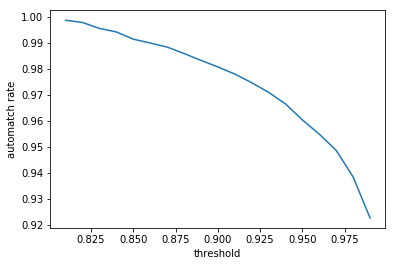

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(threshold_list, matching_size_list)
plt.xlabel('threshold')
plt.ylabel('automatch rate')
plt.show()

In [ ]:
# show dif matching id count
print(actual_df.shape)
a = actual_df[actual_df.category_id.notnull()]
b = pred_df
print(a.shape, b.shape)

x = b[~b.bar_product_id.isin(a.id.unique())].bar_product_id.unique()
y = actual_df[actual_df.id.isin(x)].id.unique()
print(len(x),len(y))

len(set(x)-set(y))
#a.merge(b, left_on='id', right_on='bar_product_id', how='outer').shape

In [ ]:
merge_category_df = actual_df.merge(pred_df, left_on='id', right_on='bar_product_id')
merge_category_df.rename(columns={'category_id_x' : 'category_id_actual', 'category_id_y' : 'category_id_pred'}, inplace=True)
merge_category_df.shape